In [1]:
%matplotlib inline

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from collections import namedtuple
from fuel.datasets.hdf5 import H5PYDataset


BATH_SIZE = 100
IMG_SIZE = 256

# Img resizing stuff
LR_HR_RATIO = 4
BIG_SIZE = int(IMG_SIZE * 76 / 64)
SMALL_SIZE = int(BIG_SIZE / LR_HR_RATIO)

DATA_TEMPLATE = '/data/ssense_%i_%i.h5'
LANGUAGE_MODEL_FILE = '/models/glove/glove.6B.50d.txt'
LANGUAGE_MODEL_VOCABULARY = '/models/glove/glove.6B.vocab'

FASTTEXT_DATA = '/data/fashion/txt/fashion.dedup.txt'
FASTTEXT_DATA_TRAIN = '/data/fashion/txt/fashion-train.txt'
FASTTEXT_DATA_CLEAN = '/data/fashion/txt/fashion-clean.txt'


OUTPUT = '/eai/project/Data/classes_and_texts.txt'

In [3]:
data_set = H5PYDataset(DATA_TEMPLATE % (IMG_SIZE, IMG_SIZE), which_sets=('all',))

In [4]:
def list_keys(data_set): 
    return [k.split('_')[1] for k in sorted(data_set.axis_labels.keys())]


In [5]:
for i, key in enumerate(list_keys(data_set)):
    print("%d %s" % (i, key))

0 brand
1 category
2 composition
3 department
4 description
5 gender
6 image
7 msrpUSD
8 name
9 productID
10 season
11 subcategory


In [6]:
Item = namedtuple('Item', ' '.join(list_keys(data_set)))

In [57]:
import string
from collections import Counter

BLACK_LIST = string.punctuation.replace('%', '') + '\n'

def normalize(text_array, 
    black_list = BLACK_LIST, 
    vocab=None, lowercase =  True, tokenize = False):
    text = text_array[0]
    if black_list:
        text = text.translate(None, BLACK_LIST)
    if lowercase:
        text = text.lower()
    if vocab:
        text = ' '.join([word for word in text.split() if word in vocab])
    if tokenize:
        return text.split()
    return text

def encode_fast_text(label, text):
    clean_label = label.lower().replace(" ", "-")
    clean_text = ' '.join(text[0][0].split())
    return "__label__%s %s\n" % (clean_label, clean_text)

In [34]:
def dump_to_fastext_corpora(data_set, output, id2category,
                            batch_size = BATH_SIZE, 
                            limit=None):
    '''
    Dumps the dataset to be consumed by fastText.
    '''
    N = data_set.num_examples
    num_batch = N / batch_size
    
    handle = data_set.open()
    with open(output, 'wr') as f:
        processed = 0
        for i in itertools.islice(xrange(num_batch), limit):
            # fetch batch of data
            text_batch, img_batch, metadata_batch  = data_set.get_data(
                handle, slice(i*batch_size, min((i+1)*batch_size, N - processed)))
            
            # process batch
            lines = [encode_fast_text(id2category[id_], text) for 
                     text, id_ in zip(text_batch, metadata_batch[:,0])]

            # dumplines
            f.writelines(lines)
            
            # track progress 
            processed += text_batch.shape[0]   
            if i % 100 == 0:
                percent = int(((100.0 * i )/ num_batch))
                print("Processing %i batch out of %i [%i processed]" % (i +1, num_batch +1, processed))

In [79]:
def dump_for_emmbeddings(
    data_set, output, 
    batch_size = BATH_SIZE, limit=None, vocab=None):
    '''
    Dumps the hdf5 dataset to flat textfile
    '''
    N = data_set.num_examples
    num_batch = N / batch_size + 1
    
    handle = data_set.open()
    with open(output, 'wr') as f:
        processed = 0
        for i in itertools.islice(xrange(num_batch), limit):
            # fetch batch of data
            low, high = i*batch_size, min((i+1)*batch_size, data_set.num_examples)
            rows = data_set.get_data(handle, slice(low, high))
            
            # process batch
            classes = [row[0].replace(" ", "_") for row in rows[1]]
            texts = [normalize(text, vocab=vocab) for text in rows[4]]
            lines = ["%s %s\n" % (c, t) for c,t in zip(classes, texts)]
            # dumplines
            f.writelines(lines)
             
            if i % 100 == 0:
                percent = int(((100.0 * i )/ num_batch))
                print("Low: %d, high: %d" % (low, high))
                print("Processing %i batch out of %i [%i processed]" % (i, num_batch, processed))
            
            # track progress 
            processed += len(texts)  

In [16]:
import itertools
import math

tokens = Counter()
classes = Counter()

handle = data_set.open()
num_batch = data_set.num_examples / BATH_SIZE
for i in xrange(num_batch):
    if i % 100 == 0:
        percent = int(((100.0 * i )/ num_batch))
        print("Processing %i batch out of %i [%i percent]" % (i, num_batch, percent))
        print("Number of tokens in the dictionary: %i" % len(tokens))
        print("Number of classes in the dictionary: %i" % len(classes))
    
    rows = data_set.get_data(
        handle, 
        slice(i*BATH_SIZE, min((i+1)*BATH_SIZE, data_set.num_examples))
    )
    
    tokens.update(itertools.chain(*[
        normalize(text, tokenize=True) for text in rows[4]
    ]))
    classes.update(itertools.chain([
        row[0] for row in rows[1]
    ]))

Processing 0 batch out of 737 [0 percent]
Number of tokens in the dictionary: 0
Number of classes in the dictionary: 0
Processing 100 batch out of 737 [13 percent]
Number of tokens in the dictionary: 4400
Number of classes in the dictionary: 20
Processing 200 batch out of 737 [27 percent]
Number of tokens in the dictionary: 5796
Number of classes in the dictionary: 25
Processing 300 batch out of 737 [40 percent]
Number of tokens in the dictionary: 6763
Number of classes in the dictionary: 44
Processing 400 batch out of 737 [54 percent]
Number of tokens in the dictionary: 7740
Number of classes in the dictionary: 48
Processing 500 batch out of 737 [67 percent]
Number of tokens in the dictionary: 8502
Number of classes in the dictionary: 49
Processing 600 batch out of 737 [81 percent]
Number of tokens in the dictionary: 9110
Number of classes in the dictionary: 49
Processing 700 batch out of 737 [94 percent]
Number of tokens in the dictionary: 9657
Number of classes in the dictionary: 49

In [12]:
print("There are %s distinct words in the dataset" % len(tokens))

There are 9882 distinct words in the dataset


In [13]:
tokens.most_common(10)

[('at', 139059),
 ('in', 114864),
 ('tonal', 80447),
 ('stitching', 69916),
 ('and', 63586),
 ('black', 49416),
 ('sleeve', 46752),
 ('collar', 42675),
 ('front', 35838),
 ('long', 28781)]

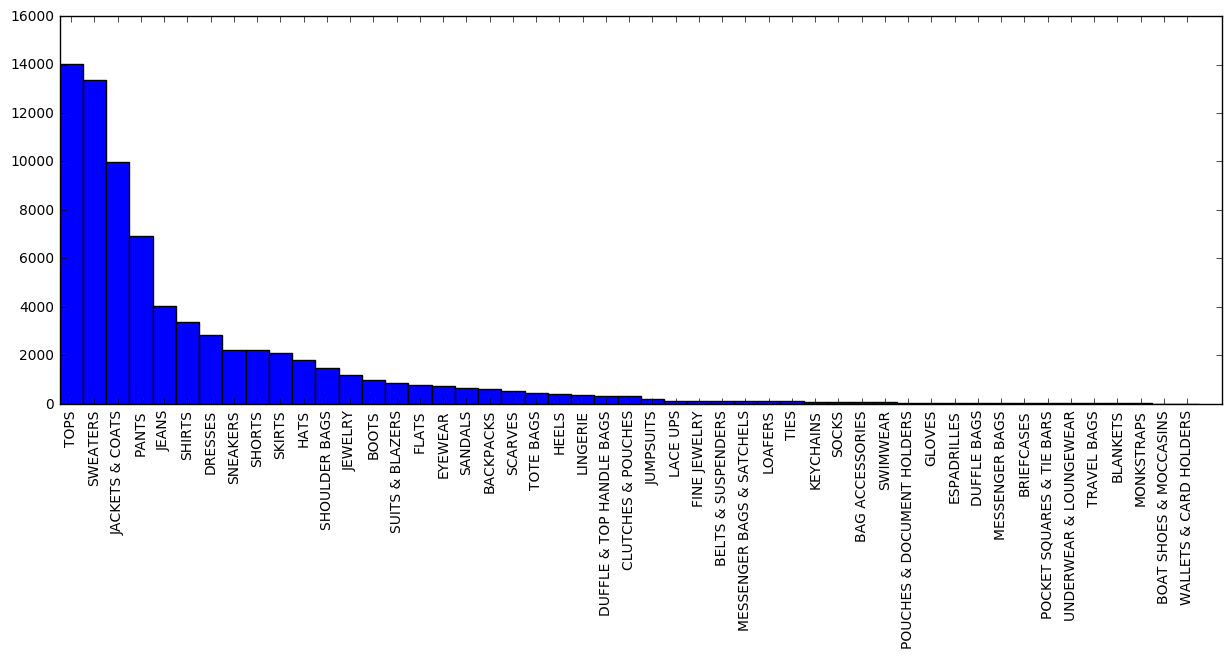

In [26]:
labels, values = zip(*classes.most_common())

indexes = np.arange(len(labels))
width = 1

plt.figure(figsize=(15, 5))
plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, labels, rotation=90)
plt.show()

# Are we missing something?

In [51]:
with open(LANGUAGE_MODEL_FILE, 'rt') as f:
    vocab = set([line.split(" ")[0] for line in f.readlines()])

In [ ]:
missing_words = Counter({ word: c[word] for word in c if word.lower() not in vocab})
print("There are %i missing words out of %i" % (len(missing_words), len(c)))
print("Most common mising words")
missing_words.most_common(10)

# Sample data

In [ ]:
import scipy.misc
import random

def clean_plot(img):
    plt.imshow(img); plt.xticks([]); plt.yticks([]); plt.show()
    
def clean_plot_dpi(img, size, dpi=60):
    plt.figure().set_size_inches(float(size)/float(dpi),float(size)/float(dpi))
    plt.xticks([]); plt.yticks([]);
    plt.imshow(img);

In [ ]:
i = random.randint(0, data_set.num_examples)
item = Item._make(data_set.get_data(handle, slice(i, min((i+1), data_set.num_examples))))

In [ ]:
plt.title(item.category[0][0])
plt.imshow(item.image[0]);
print("Raw text: \n%s\n" % item.description[0][0])
print("Normalized text: \n%s\n" %  ' '.join(
    normalize(item.description[0], tokenize=True)))
print("Normalized text with vocab: \n%s\n" %  ' '.join(
    normalize(item.description[0], vocab=vocab, tokenize=True)))
plt.show()

## To be consistent with StackGAN

In [ ]:
img = item.image[0]
img_76 = scipy.misc.imresize(img, [SMALL_SIZE, SMALL_SIZE], 'bicubic')
img_304 = scipy.misc.imresize(img, [BIG_SIZE, BIG_SIZE], 'bicubic')

In [ ]:
clean_plot_dpi(img_76, SMALL_SIZE); clean_plot_dpi(img_304, BIG_SIZE);

# Text preprocessing for fastText

In [ ]:
from random import sample

def clean_line(text):
    return text.translate(None, BLACK_LIST).lower()

def process(line):
    label, text = line.split(" ", 1)
    return "%s %s\n" % (label, clean_line(line))

def strip(line):
    _, text = line.split(" ", 1)
    return "%s\n" % clean_line(text)

with open(FASTTEXT_DATA, 'rt') as f:
    all_lines = f.readlines()
    lines = list(set(all_lines))

with open(FASTTEXT_DATA_TRAIN, 'wt') as f:
    f.writelines(sample([process(line) for line in lines], len(lines)))
    
with open(FASTTEXT_DATA_CLEAN, 'wt') as f:
    f.writelines([strip(line) for line in all_lines])

In [ ]:
from tensorflow.python.client import device_lib

In [ ]:
print(device_lib.list_local_devices())

# Dump data for text embedding with CNNN

In [78]:
dump_for_emmbeddings(data_set, OUTPUT, batch_size = BATH_SIZE, vocab=None)

Low: 0, high: 100
Processing 0 batch out of 738 [0 processed]
Low: 10000, high: 10100
Processing 100 batch out of 738 [10000 processed]
Low: 20000, high: 20100
Processing 200 batch out of 738 [20000 processed]
Low: 30000, high: 30100
Processing 300 batch out of 738 [30000 processed]
Low: 40000, high: 40100
Processing 400 batch out of 738 [40000 processed]
Low: 50000, high: 50100
Processing 500 batch out of 738 [50000 processed]
Low: 60000, high: 60100
Processing 600 batch out of 738 [60000 processed]
Low: 70000, high: 70100
Processing 700 batch out of 738 [70000 processed]
